## PART 1: Data Processing 

### Required:
- python
- pandas
- jupyter
- notebook
- matplotlib
- seaborn

```
pip install dtwhaclustering
```


__Author: Utpal Kumar @Institute of Earth Sciences, Academia Sinica__

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import glob, os
import matplotlib.pyplot as plt
import seaborn as sns
from dtwhaclustering.analysis_support import dec2dt
from functools import reduce
from dtwhaclustering.analysis_support import toYearFraction as tyf
import scipy.io as sio
%matplotlib inline

In [8]:
## default matplotlib parameters
import matplotlib
font = {'family' : 'Times',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (12, 6)
matplotlib.rcParams['pdf.fonttype'] = 42

### Read Data

In [3]:
datasource="data/" #data is stored in this directory
all_data_files=glob.glob(datasource+"*.COR") ##all data file names
print("Total station data to begin with: ", len(all_data_files))

Total station data to begin with:  394


Read COR files to build start and end times of all stations

In [4]:
## extract the start time, end time and number of points in the time series for each stations
datalength_list = []
for dfile in all_data_files:
    _mydict = {}
    df=pd.read_csv(dfile,header=None,sep='\s+')
    stn=dfile.split("/")[1].split(".")[0]

    stime=df.iloc[:,0].min()
    etime=df.iloc[:,0].max()

    tdataPoints=df.shape[0]
    _mydict['stn'] = stn
    _mydict['stime'] = stime
    _mydict['etime'] = etime
    _mydict['tdataPoints'] = tdataPoints
    datalength_list.append(_mydict)
    
datalength = pd.DataFrame(datalength_list)
datalength.head()

,stn,stime,etime,tdataPoints
0,YSLL,2007.00137,2018.32650,3557
1,GUKN,2003.00137,2018.32650,5269
2,SANL,2006.92213,2018.32650,4104
3,CKGM,2006.06421,2008.99863,1055
4,WCRS,2013.24727,2018.24454,1697


### Histogram of the data availability

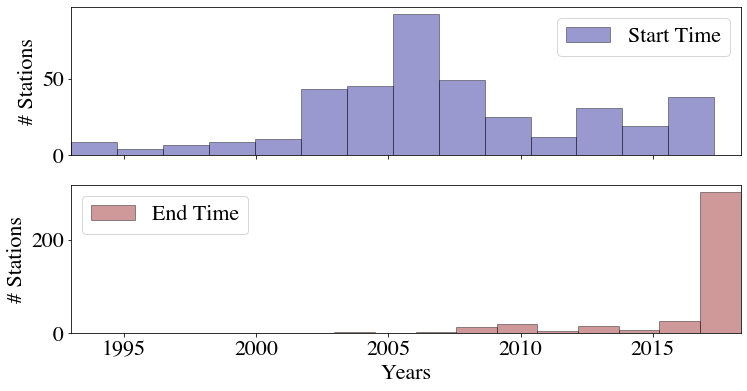

In [12]:
fig,ax=plt.subplots(2,1,sharex=True)
sns.distplot(datalength['stime'].values, hist=True, kde=False, bins='auto', color = 'darkblue', hist_kws={'edgecolor':'black', "label": "Start Time"},ax=ax[0])
ax[0].legend()
ax[0].set_ylabel('# Stations')
sns.distplot(datalength['etime'].values, hist=True, kde=False, bins=10, color = 'darkred', hist_kws={'edgecolor':'black', "label": "End Time"},ax=ax[1])
ax[1].set_xlabel('Years')
ax[1].legend()
ax[1].set_ylabel('# Stations')
plt.xlim(datalength['stime'].min(), datalength['etime'].max())
# plt.savefig('s_e_timeHistogram.png',bbox_inches='tight')
# plt.close()
# plt.show()
plt.savefig('Figures/data_availability.pdf',bbox_inches='tight')

### Select the data files between 2007-2018 and npts=4000 [360*11 = 3960] days

In [6]:
starttime = 2007
endtime = 2018
selData=datalength[(datalength['stime']<starttime) & (datalength['etime']>endtime) & (datalength['tdataPoints']>4000)]

In [7]:
## New Selected Data
selstns_all=selData['stn'].values
print("Number of stations selected: ",len(selstns_all))

## Writing all selected data into a data frame
main_dU=[]
main_dN=[]
main_dE=[]
for s1 in selstns_all:
    duu='{}_U'.format(s1)
    dnn='{}_N'.format(s1)
    dee='{}_E'.format(s1)
    selGroundMotion=pd.read_csv(os.path.join(datasource,s1+'.COR'),header=None,delimiter=r'\s+',names=['year','lat','lon','hgt','dN','dE','dU','FLAG(reserved)'])
    timeVal=dec2dt(selGroundMotion.values[:,0])
    selGroundMotion["Time"]=timeVal
    selGroundMotion.set_index("Time",inplace=True)
    
    # Extracting data between start and end time and renaming the columns
    df2=selGroundMotion.loc[(selGroundMotion.year>starttime) & (selGroundMotion.year<endtime),['dN','dE','dU']].rename(columns={'dN':dnn,'dE':dee,'dU':duu})
    # Removing the 2-sigma outliers
    df2=df2[(np.abs(df2[dnn]-df2[dnn].mean())<=2*df2[dnn].std()) | (np.abs(df2[dee]-df2[dee].mean())<=2*df2[dee].std()) | (np.abs(df2[duu]-df2[duu].mean())<=2*df2[duu].std())]


    # # # Resampling the data for each day and interpolating for unavailable entries
    df3=df2.resample('D').last().interpolate(method='nearest')
    # df3=df2 #no interpolation
    # Storing each station data in a single list separately for dN, dE and dU
    main_dN.append(df3[dnn])
    main_dE.append(df3[dee])
    main_dU.append(df3[duu])

# Concatenating all the data frames in the list to make a single data frame
dNN=reduce(lambda x, y: pd.concat([x, y],axis=1), main_dN)
dEE=reduce(lambda x, y: pd.concat([x, y],axis=1), main_dE)
dUU=reduce(lambda x, y: pd.concat([x, y],axis=1), main_dU)

## Remove stations with missing data in the beginning or end
allcols=dUU.columns.values
cols_remU=[]
for i in range(len(allcols)):
    #check first and last row
    if np.isnan(dUU.iloc[0,i]) or np.isnan(dUU.iloc[-1,i]):
        cols_remU.append(allcols[i])

allcolsE=dEE.columns.values
cols_remE=[]
for i in range(len(allcolsE)):
    if np.isnan(dEE.iloc[0,i]) or np.isnan(dEE.iloc[-1,i]):
        cols_remE.append(allcolsE[i])

allcolsN=dNN.columns.values
cols_remN=[]
for i in range(len(allcolsN)):
    if np.isnan(dNN.iloc[0,i]) or np.isnan(dNN.iloc[-1,i]):
        cols_remN.append(allcolsN[i])


dUU=dUU.drop(cols_remU, axis=1)
dNN=dNN.drop(cols_remN, axis=1)
dEE=dEE.drop(cols_remE, axis=1)
dNN.head()

Number of stations selected:  130


,GUKN_N,SANL_N,GS26_N,GS32_N,GS33_N,GS27_N,NAAO_N,PEPU_N,SJPU_N,GS31_N,...,GS15_N,GS28_N,TTUN_N,DNAN_N,MESN_N,W029_N,GS16_N,WULU_N,NSHE_N,DOSH_N
Time,,,,,,,,,,,,,,,,,,,,,
2007-01-01,24.6975,5.0061,54.8501,125.8736,67.347,53.0162,137.3159,12.6388,28.799,70.8631,...,43.1697,65.6211,24.0489,43.7497,21.4439,13.7696,38.2605,2.272,16.5592,36.731
2007-01-02,22.0375,3.6491,52.4371,122.5586,64.319,50.5542,134.7059,10.4888,27.028,67.8741,...,40.1047,63.3901,20.5759,41.7927,18.0959,10.8796,36.2345,3.467,14.1342,33.040
2007-01-03,24.9445,8.2681,56.8621,123.6756,65.158,54.4252,135.9669,13.7198,26.643,69.3861,...,43.8597,64.8591,23.8659,44.4017,18.8799,14.4586,39.1175,2.879,17.2872,35.318
2007-01-04,24.9675,5.9921,53.6851,124.6046,65.157,53.4662,137.3339,10.7828,29.478,70.1601,...,43.3727,64.4671,23.3689,43.9457,18.3269,13.1216,39.1175,5.414,15.9102,34.718
2007-01-05,23.4255,3.9261,54.0341,122.7396,64.487,52.3292,136.1929,10.1318,25.922,68.5661,...,40.9967,63.4591,21.8369,41.3427,18.1249,11.5586,36.9255,4.548,14.1612,34.029


### Save into pickle file and mat file (MATLAB purpose) for later use

In [8]:
selected_data = "pickleFiles"
os.makedirs(selected_data, exist_ok=True) #don't make if already exists

dUU.to_pickle(os.path.join(selected_data,"dU_data.pickle"))
dNN.to_pickle(os.path.join(selected_data,"dN_data.pickle"))
dEE.to_pickle(os.path.join(selected_data,"dE_data.pickle"))

# ## create new column of "year" with decimal year values instead of string
# year = []
# for dd in dUU.index:
#     year.append(round(tyf(dd), 5))
# dUU['year'] = year
# dNN['year'] = year
# dEE['year'] = year


# # Save into mat file
# sio.savemat(os.path.join(selected_data,'dU_data.mat'), {name: col.values for name, col in dUU.items()})
# sio.savemat(os.path.join(selected_data,'dN_data.mat'), {name: col.values for name, col in dNN.items()})
# sio.savemat(os.path.join(selected_data,'dE_data.mat'), {name: col.values for name, col in dEE.items()})